DiracNets
=========

In this notebook we provide DiracNet-18-v2 (11.7M parameters) model definitions with pretrained weights.
The model was trained in PyTorch on ILSVRC2012 train set.

top-1 and top-5 errors on ILSVRC2012 validation set:
**30.37, 10.88**

Here is the parameterization we used to train DiracNets-v2:

$$\mathbf{y} = \mathrm{diag}(\mathbf{a}) \mathbf{I} + \mathrm{diag}(\mathbf{b}) \mathbf{W}_\mathrm{norm},$$

where $\mathbf{W}_\mathrm{norm}$ is $l_2$ normalized weight vector.

In [1]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn

# Original model (unfolded)

In [2]:
data = torch.load('./data/diracnet18-v2_checkpoint.pth', map_location='cpu')
params = {k: Variable(v) for k, v in data['params'].items()}

print('Total parameters:', sum(v.numel() for v in params.values()))

Total parameters: 11523368


In [3]:
def size2name(size):
    return 'eye' + '_'.join(map(str, size))

def batch_norm(x, params, stats, base, mode):
    return F.batch_norm(x, weight=params[base + '.weight'],
                        bias=params[base + '.bias'],
                        running_mean=stats[base + '.running_mean'],
                        running_var=stats[base + '.running_var'],
                        training=mode)

def define_diracnet(depth):
    definitions = {18: [2,2,2,2], 34: [3,4,6,3]}
    blocks = definitions[depth]

    def block(o, params, stats, base, mode, j):
        w = params[base + '.conv']
        alpha = params[base + '.alpha'].view(-1,1,1,1)
        beta = params[base + '.beta'].view(-1,1,1,1)
        delta = Variable(stats[size2name(w.size())])
        w_hat = beta * F.normalize(w.view(w.size(0), -1)).view_as(w) + alpha * delta
        o = F.conv2d(F.relu(o), w_hat, stride=1, padding=1)
        o = batch_norm(o, params, stats, base + '.bn', mode)
        return o


    def group(o, params, stats, base, mode, count):
        for i in range(count):
            o = block(o, params, stats, '%s.block%d' % (base, i), mode, i)
        return o
    
    def f(inputs, params, stats, mode):
        o = F.conv2d(inputs, params['conv'], padding=3, stride=2)
        o = batch_norm(o, params, stats, 'bn', mode)
        o = F.max_pool2d(o, 3, 2, 1)
        o = group(o, params, stats, 'group0', mode, blocks[0] * 2)
        o = F.max_pool2d(o, 2)
        o = group(o, params, stats, 'group1', mode, blocks[1] * 2)
        o = F.max_pool2d(o, 2)
        o = group(o, params, stats, 'group2', mode, blocks[2] * 2)
        o = F.max_pool2d(o, 2)
        o = group(o, params, stats, 'group3', mode, blocks[3] * 2)
        o = F.avg_pool2d(F.relu(o), o.size(-1))
        o = F.linear(o.view(o.size(0), -1), params['fc.weight'], params['fc.bias'])
        return o
    
    return f

In [4]:
inputs = torch.randn(1,3,224,224)
y_unfolded = define_diracnet(18)(Variable(inputs), params, data['stats'], False)
print(y_unfolded)

Variable containing:
 0.6537  1.6989 -0.9675  ...  -0.5209 -0.0075  2.6128
[torch.FloatTensor of size 1x1000]



## Fold Dirac and BatchNorm into weights

In [5]:
def fold(params, stats):
    params_fold = {}

    def fold_bn(base):
        running_mean = stats[base + '.running_mean']
        running_var = stats[base + '.running_var']
        weight = params[base + '.weight']
        bias = params[base + '.bias']
        a = weight / torch.sqrt(running_var + 1e-5)
        b = - running_mean * a + bias
        return a, b

    for k, w in params.items():
        if k.endswith('.conv'):
            alpha = params[k.replace('.conv', '.alpha')].view(-1,1,1,1)
            beta = params[k.replace('.conv', '.beta')].view(-1,1,1,1)
            delta = stats['eye' + '_'.join(map(str, w.size()))]
            w_hat = beta * F.normalize(w.view(w.size(0), -1)).view_as(w) + alpha * delta
            a, b = fold_bn(k.replace('.conv', '.bn'))
            params_fold[k + '.weight'] = a.view(-1,1,1,1).expand_as(w) * w_hat
            params_fold[k + '.bias'] = b
        elif k == 'conv':
            a, b = fold_bn('bn')
            params_fold['conv.weight'] = a.view(-1,1,1,1).expand_as(w) * w 
            params_fold['conv.bias'] = b
        elif not k.endswith('.alpha') and not k.endswith('.beta') \
                and not k.endswith('bn.weight') and not k.endswith('bn.bias'):
            params_fold[k] = w
    stats_fold = {}
    return params_fold

params_folded = fold({k: v.data for k, v in params.items()}, data['stats'])

# Functional definition

In [6]:
def define_diracnet_folded(depth):
    definitions = {18: [2,2,2,2], 34: [3,4,6,3]}
    blocks = definitions[depth]

    def f(inputs, params):
        o = F.conv2d(inputs, params['conv.weight'], params['conv.bias'], padding=3, stride=2)
        o = F.max_pool2d(o, 3, 2, 1)
        for group_i, n_blocks in enumerate(blocks):
            for block_i in range(n_blocks * 2):
                block_name = 'group%d.block%d.conv.' % (group_i, block_i)
                o = F.conv2d(F.relu(o), weight=params[block_name + 'weight'],
                             bias=params[block_name + 'bias'], padding=1)
            if group_i != 3:
                o = F.max_pool2d(o, 2)
            else:
                o = F.avg_pool2d(F.relu(o), o.size(-1))
        o = F.linear(o.view(o.size(0), -1), params['fc.weight'], params['fc.bias'])
        return o
    
    return f

In [7]:
params_folded_vars = {k: Variable(v, requires_grad=True) for k, v in params_folded.items()}
y_folded = define_diracnet_folded(18)(Variable(inputs), params_folded_vars)
y_folded - y_unfolded

Variable containing:
1.00000e-06 *
 0.8345  1.5497  0.7153  ...   1.4901  0.1788  2.1458
[torch.FloatTensor of size 1x1000]

# Module definition

In [8]:
from diracnet import diracnet18
model = diracnet18(pretrained=True)
model

DiracNet(
  (features): Sequential(
    (conv): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (max_pool0): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
    (group0.block0.relu): ReLU()
    (group0.block0.conv): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (group0.block1.relu): ReLU()
    (group0.block1.conv): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (group0.block2.relu): ReLU()
    (group0.block2.conv): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (group0.block3.relu): ReLU()
    (group0.block3.conv): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (max_pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (group1.block0.relu): ReLU()
    (group1.block0.conv): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (group1.block1.relu): ReLU()
    (group1.bl

In [9]:
state_dict = {'features.' + k if not k.startswith('fc') else k: v
              for k, v in params_folded.items()}
model.load_state_dict(state_dict)
torch.save(state_dict, './data/diracnet18v2folded.pth')

Check against functional model:

In [10]:
x = Variable(inputs)
params_folded_vars = {k: Variable(v) for k, v in params_folded.items()}
(model(x) - define_diracnet_folded(18)(x, params_folded_vars)).abs().sum().data[0]

0.0

## Visualize filters of folded layer

Populating the interactive namespace from numpy and matplotlib


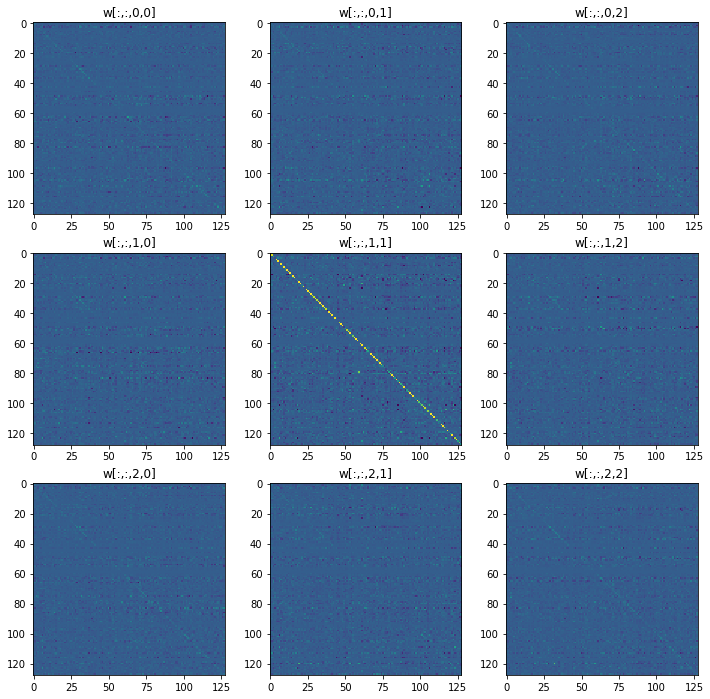

In [11]:
%pylab inline

plt.figure(figsize=(12,12))
w = params_folded['group1.block3.conv.weight'].numpy()
wmin, wmax = w.min() * 0.5, w.max() * 0.05
for i in range(3):
    for j in range(3):
        plt.subplot2grid(shape=(3,3), loc=(i, j))
        plt.imshow(w[:,:,i,j], vmin=wmin, vmax=wmax)
        plt.title('w[:,:,{},{}]'.format(i, j))

# Same for DiracNet-34

In [13]:
data = torch.load('./data/diracnet34-v2_checkpoint.pth', map_location='cpu')
params = {k: Variable(v) for k, v in data['params'].items()}

print('Total parameters:', sum(v.numel() for v in params.values()))

Total parameters: 21638952


In [14]:
y_unfolded = define_diracnet(34)(Variable(inputs), params, data['stats'], False)
print(y_unfolded)

Variable containing:
-0.6339 -0.9981 -2.0489  ...   0.4225 -1.0342  0.3068
[torch.FloatTensor of size 1x1000]



In [20]:
params_folded = fold({k: v.data for k, v in params.items()}, data['stats'])

In [21]:
params_folded_vars = {k: Variable(v, requires_grad=True) for k, v in params_folded.items()}
y_folded = define_diracnet_folded(34)(Variable(inputs), params_folded_vars)
y_folded - y_unfolded

Variable containing:
1.00000e-06 *
-0.2384  0.5364  4.7684  ...   2.1458  0.9537  3.8445
[torch.FloatTensor of size 1x1000]

In [22]:
state_dict = {'features.' + k if not k.startswith('fc') else k: v
              for k, v in params_folded.items()}
torch.save(state_dict, './data/diracnet34v2folded.pth')

In [23]:
from diracnet import diracnet34
model = diracnet34(pretrained=True)
model

DiracNet(
  (features): Sequential(
    (conv): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (max_pool0): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
    (group0.block0.relu): ReLU()
    (group0.block0.conv): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (group0.block1.relu): ReLU()
    (group0.block1.conv): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (group0.block2.relu): ReLU()
    (group0.block2.conv): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (group0.block3.relu): ReLU()
    (group0.block3.conv): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (group0.block4.relu): ReLU()
    (group0.block4.conv): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (group0.block5.relu): ReLU()
    (group0.block5.conv): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (max_pool1): M

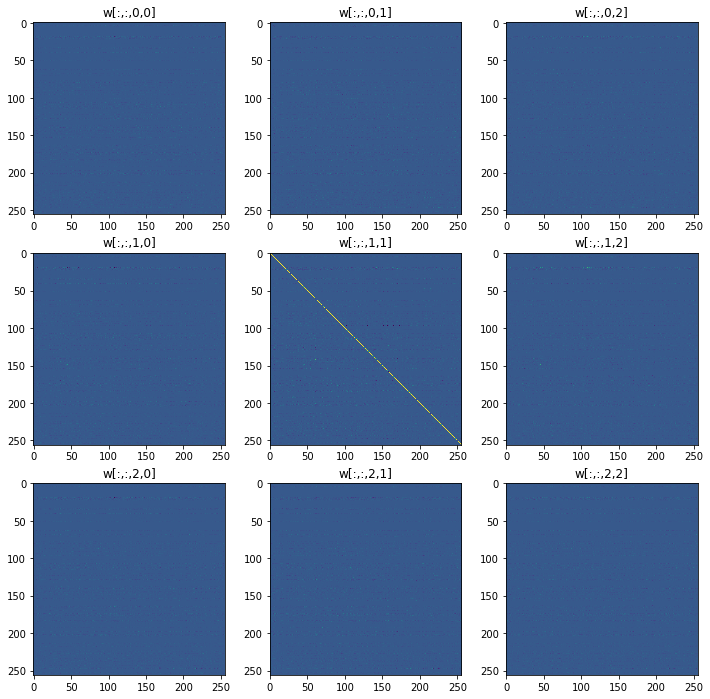

In [24]:
plt.figure(figsize=(12,12))
w = params_folded['group2.block4.conv.weight'].numpy()
wmin, wmax = w.min() * 0.5, w.max() * 0.05
for i in range(3):
    for j in range(3):
        plt.subplot2grid(shape=(3,3), loc=(i, j))
        plt.imshow(w[:,:,i,j], vmin=wmin, vmax=wmax)
        plt.title('w[:,:,{},{}]'.format(i, j))